In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats


df = pd.read_csv("./data/ImmoDataRuhr.csv")
df = df.rename(columns={"regio2": "city", "sqmPrice": "price"})
cities = ["Bochum","Dortmund", "Duisburg", "Essen"]
PRICENAME = "Price per sqm in Euros"

In [3]:
# cleaning the data:
print(df[df["price"].isna()])
# --> no missing data

Empty DataFrame
Columns: [ID, price, city]
Index: []


In [32]:

print(df[["price"]].describe().round(decimals=2))

for c in cities:
    print("\n" + c)
    print(df[["price"]][df["city"] == c].describe().round(decimals=2))

print(df.groupby("city").var())



        price
count  200.00
mean     9.15
std      1.29
min      5.84
25%      8.29
50%      9.18
75%      9.90
max     13.63

Bochum
       price
count  50.00
mean    9.15
std     1.33
min     5.84
25%     8.36
50%     9.18
75%     9.74
max    12.71

Dortmund
       price
count  50.00
mean    9.53
std     1.36
min     6.66
25%     8.54
50%     9.55
75%    10.46
max    13.63

Duisburg
       price
count  50.00
mean    8.62
std     1.14
min     6.67
25%     7.75
50%     8.66
75%     9.45
max    11.10

Essen
       price
count  50.00
mean    9.30
std     1.19
min     6.25
25%     8.44
50%     9.28
75%    10.09
max    12.28
                    ID     price
city                            
Bochum    1.123468e+07  1.756367
Dortmund  1.705005e+07  1.838011
Duisburg  1.072650e+07  1.302325
Essen     1.192412e+07  1.411001


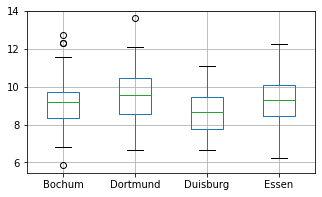

In [31]:
# boxplots
fig, ax = plt.subplots()
fig.set_size_inches(5, 3)
df.boxplot(column="price",by="city", ax = ax,)
ax.set_xlabel("")
ax.set_title("")
fig.suptitle ("") #("Boxplots for rental price in Euro")
fig.savefig(f"./latex/images/boxplot.png", format='png', dpi=200)
plt.show()


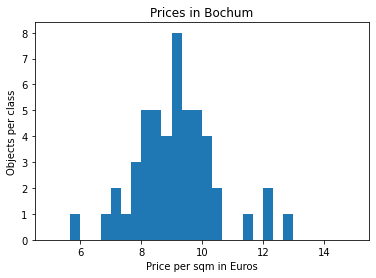

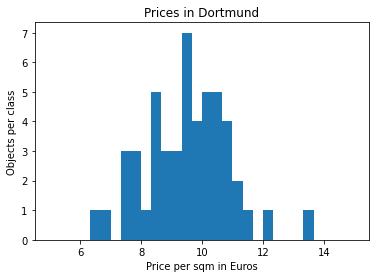

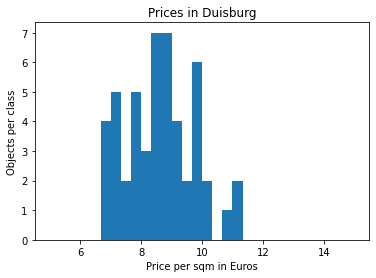

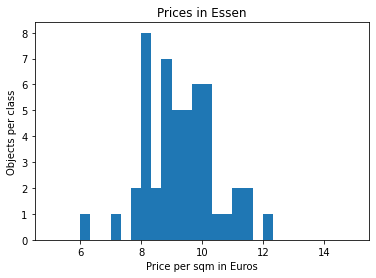

In [4]:

# test residuals qpproximately normal distributed
# just looking at histogram
for c in cities:
    arr = df[df["city"] == c]["price"]
    bins = np.arange(5,15,0.333333)
    fig, ax = plt.subplots()
    plt.hist(arr, bins=bins)
    ax.set_title("Prices in " + c)
    ax.set_xlabel(PRICENAME)
    ax.set_ylabel("Objects per class")
    fig.savefig(f"./latex/images/{c}-histogram.png", format='png', dpi=150)
    plt.show()

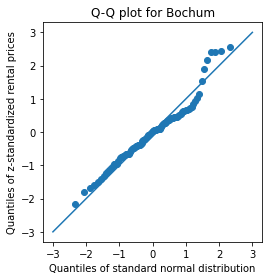

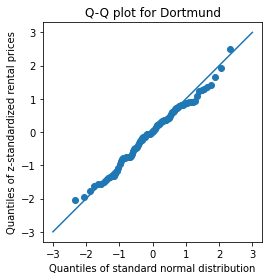

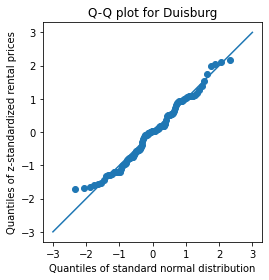

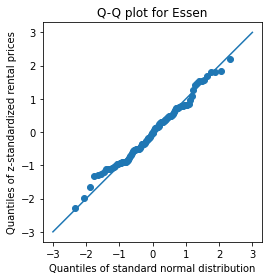

In [43]:
# qq plot with normal distribution:
linelimit = 3
quantilecount = 100
for c in cities:

    fig.set_size_inches(3, 3)
    arr = df[df["city"] == c]["price"]
    mean = np.mean(arr)
    std = np.std(arr, ddof=0)
    quantilesSample = []
    quantilesNormal = []
    for i in range(quantilecount+1):
        q = i/quantilecount
        quantilesSample.append((np.quantile(arr,q)-mean)/std)
        quantilesNormal.append(stats.norm.ppf(q))
    fig, ax = plt.subplots()
    ax.set_title("Q-Q plot for " + c)
    ax.set_ylabel("Quantiles of z-standardized rental prices")
    ax.set_xlabel("Quantiles of standard normal distribution")
    plt.scatter(x= quantilesNormal, y=quantilesSample)
    plt.plot([-linelimit,linelimit],[-linelimit,linelimit])
    plt.axis('scaled')
    plt.tight_layout()
    fig.savefig(f"./latex/images/qqplot-{c}.png", format='png', dpi=300)
    plt.show()

In [6]:
# homoscedasticity or Homogeneity of variances: variances equal within groups?

for c in cities:
    arr = df[df["city"] == c]["price"]
    print(f"Variance in {c}: {np.std(arr, ddof=0)**2}")

# they vary only by a factor of up to 1.41 which is okay.

Variance in Bochum: 1.721239273911677
Variance in Dortmund: 1.801250712661998
Variance in Duisburg: 1.276278179025029
Variance in Essen: 1.382781319087682


In [46]:
# Anova with

cityToData = {
    city: [p for p in df[df["city"] == city]["price"]] for city in cities
}

# this uses f_oneway, while in doAnovaDetail the squaresums are calculated by myself.


def doAnova(cityList, alpha=0.05):
    cityData = [cityToData[c] for c in cityList]
    F, p = stats.f_oneway(*cityData)
    Fkrit = stats.f.ppf(1-alpha, dfn=len(cityList)-1, dfd=49 * len(cityList))
    citystring = ", ".join(cityList)
    significant = "*" if p <= alpha else " "
    print(f"""Anova for cities: {citystring}
    F: {F}, Fkrit: {Fkrit}, alpha: {alpha}, p: {p} {significant}
    -------------------------------------------
    """)


def doAnovaDetail(cityList, alpha=0.05, printing = True):
    #cityData = {c: cityToData[c] for c in cityList}
    grandMean = 0
    for c in cityList:
        for v in cityToData[c]:
            grandMean += v
    grandMean = grandMean / (len(cityList)*50)
    cityMeans = {c: np.mean(cityToData[c]) for c in cityList}
    SStot, SSbet, SSinn = 0, 0, 0
    for c in cityList:
        for v in cityToData[c]:
            SStot += (v - grandMean)**2
            SSbet += (cityMeans[c] - grandMean)**2
            SSinn += (v - cityMeans[c])**2
    dfbet, dfinn = len(cityList)-1, 49 * len(cityList)
    MQSbet = SSbet / dfbet
    MQSinn = SSinn / dfinn
    F = MQSbet / MQSinn
    Fkrit = stats.f.ppf(1-alpha, dfn=len(cityList)-1, dfd=49 * len(cityList))
    p = 1 - stats.f.cdf(F, dfn=len(cityList)-1, dfd=49 * len(cityList))
    details = {
        "cities": cityList,
        "alpha": alpha,
        "p": p,
        "F": F,
        "Fkrit": Fkrit,
        "Significant": "yes!" if F >= Fkrit else "no!",
        "SStot": SStot, "SSbet": SSbet,
        "SSinn": SSinn, "dfbet": dfbet,
        "dfinn": dfinn,  "MQSbet": MQSbet,
        "MQSinn": MQSinn,
    }
    if(printing):
        print(details)
        print("-------------------------------------------------")
    return details



doAnovaDetail(["Dortmund", "Bochum", "Duisburg", "Essen"], alpha=0.05)


doAnovaDetail(["Dortmund", "Bochum"], alpha=0.05)
doAnovaDetail(["Dortmund", "Bochum"], alpha=0.05/6)

doAnovaDetail(["Dortmund", "Duisburg"], alpha=0.05)
doAnovaDetail(["Dortmund", "Duisburg"], alpha=0.05/6)

doAnovaDetail(["Dortmund", "Essen"], alpha=0.05)
doAnovaDetail(["Dortmund", "Essen"], alpha=0.05/6)

doAnovaDetail(["Bochum", "Duisburg"], alpha=0.05)
doAnovaDetail(["Bochum", "Duisburg"], alpha=0.05/6)

doAnovaDetail(["Bochum", "Essen"], alpha=0.05)
doAnovaDetail(["Bochum", "Essen"], alpha=0.05/6)

doAnovaDetail(["Duisburg", "Essen"], alpha=0.05)
doAnovaDetail(["Duisburg", "Essen"], alpha=0.05/6)


{'cities': ['Dortmund', 'Bochum', 'Duisburg', 'Essen'], 'alpha': 0.05, 'p': 0.0035078387959125434, 'F': 4.681087244574568, 'Fkrit': 2.6506765101121257, 'Significant': 'yes!', 'SStot': 331.22265722753747, 'SSbet': 22.14518299321832, 'SSinn': 309.0774742343193, 'dfbet': 3, 'dfinn': 196, 'MQSbet': 7.381727664406107, 'MQSinn': 1.5769258889506088}
-------------------------------------------------
{'cities': ['Dortmund', 'Bochum'], 'alpha': 0.05, 'p': 0.16472482873657002, 'F': 1.9594970515454255, 'Fkrit': 3.938111078003373, 'Significant': 'no!', 'SStot': 179.64608542194372, 'SSbet': 3.5215860932598995, 'SSinn': 176.12449932868378, 'dfbet': 1, 'dfinn': 98, 'MQSbet': 3.5215860932598995, 'MQSinn': 1.7971887686600385}
-------------------------------------------------
{'cities': ['Dortmund', 'Bochum'], 'alpha': 0.008333333333333333, 'p': 0.16472482873657002, 'F': 1.9594970515454255, 'Fkrit': 7.251539058150055, 'Significant': 'no!', 'SStot': 179.64608542194372, 'SSbet': 3.5215860932598995, 'SSinn'

{'cities': ['Duisburg', 'Essen'],
 'alpha': 0.008333333333333333,
 'p': 0.004499037787279669,
 'F': 8.45670409938422,
 'Fkrit': 7.251539058150055,
 'Significant': 'yes!',
 'SStot': 144.42587253736826,
 'SSbet': 11.47289763173281,
 'SSinn': 132.95297490563553,
 'dfbet': 1,
 'dfinn': 98,
 'MQSbet': 11.47289763173281,
 'MQSinn': 1.3566630092411789}

In [54]:
# pattern:    City-Pair      & $SS_{total}$ & $SS_{between}$ & $SS_{within}$ & $MQS_{between}$ & $MQS_{within}$ & $F$ & $p$   \\
def printAnovaDetailsForLatex(details):
    digits = 3
    s =  " - ".join(details["cities"]) \
        + " & " + str(round(details["SStot"], digits)) \
        + " & " + str(round(details["SSbet"], digits)) \
        + " & " + str(round(details["SSinn"], digits)) \
        + " & " + str(round(details["MQSbet"], digits)) \
        + " & " + str(round(details["MQSinn"], digits)) \
        + " & " + str(round(details["F"],digits)) \
        + " & " + str(round(details["p"], 4))
    print(s)


printAnovaDetailsForLatex(doAnovaDetail(
    ["Dortmund", "Duisburg"], alpha=0.05, printing=False))
printAnovaDetailsForLatex(doAnovaDetail(
    ["Dortmund", "Bochum"], alpha=0.05, printing=False))
printAnovaDetailsForLatex(doAnovaDetail(
    ["Dortmund", "Essen"], alpha=0.05, printing=False))

printAnovaDetailsForLatex(doAnovaDetail(
    ["Duisburg", "Bochum"], alpha=0.05, printing=False))
printAnovaDetailsForLatex(doAnovaDetail(
    ["Duisburg", "Essen"], alpha=0.05, printing=False))

printAnovaDetailsForLatex(doAnovaDetail(
    ["Bochum", "Essen"], alpha=0.05, printing=False))


Dortmund - Duisburg & 174.332 & 20.455 & 153.876 & 20.455 & 1.57 & 13.027 & 0.0005
Dortmund - Bochum & 179.646 & 3.522 & 176.124 & 3.522 & 1.797 & 1.959 & 0.1647
Dortmund - Essen & 160.491 & 1.29 & 159.202 & 1.29 & 1.625 & 0.794 & 0.3751
Duisburg - Bochum & 156.878 & 7.002 & 149.876 & 7.002 & 1.529 & 4.578 & 0.0349
Duisburg - Essen & 144.426 & 11.473 & 132.953 & 11.473 & 1.357 & 8.457 & 0.0045
Bochum - Essen & 155.75 & 0.549 & 155.201 & 0.549 & 1.584 & 0.347 & 0.5573
